# Correlation Cross-Prediction

This script correlates a participant's functional connectivity matrix against all other participants, or an age bin's functional connectivity matrices against another age bin.

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data
from common.paths import HEALTHY, ADHD

X, _, demographics, population = get_data(wisc_level=5, label_path=ADHD)
ages = demographics['Age']

print(f'X: {X.shape} | Age: {ages.shape} | Population: {population}')

X: (373, 34716) | Age: (373,) | Population: adhd


In [130]:
from common.data import filter_data_by_network
from common.power_atlas import POWER_NETWORKS

network = 'CON'
X = filter_data_by_network(X, POWER_NETWORKS[network], True, False)

print(X.shape)

(373, 91)


In [3]:
from common.binning import bin_data, ONLY_BIN_LABELS

X_bins, _, bin_labels = bin_data(X, ages, ages, False, 3)
X_bins[0] = np.delete(X_bins[0], 51, axis=0)

for age_bin, bin_label in zip(X_bins, bin_labels):
    print(f'{bin_label}: {age_bin.shape}')

Bin 1: (113, 34716)
Bin 2: (147, 34716)
Bin 3: (112, 34716)


### Generate fake data

In [95]:
from common.data import generate_fake_data

X, _ = generate_fake_data(X, np.zeros(1))

print(f'X: {X.shape}')

X: (373, 34716)


## Correlation

In [20]:
from scipy import stats
from sklearn.model_selection import LeaveOneOut

### Correlate every sample (all combinations)

In [96]:
%%time
correlations = []

for index, curr_subject in enumerate(X):
    for next_subject in X[index + 1:len(X) + 1]:
        correlations.append(stats.pearsonr(curr_subject, next_subject)[0])

print(f'Num correlations: {len(correlations)}')

Num correlations: 69378
CPU times: user 3min 57s, sys: 2.69 s, total: 4min
Wall time: 24.1 s


Text(0.5, 1.0, 'method=all, population=adhd (generated), n=373, num_correlations=69378')

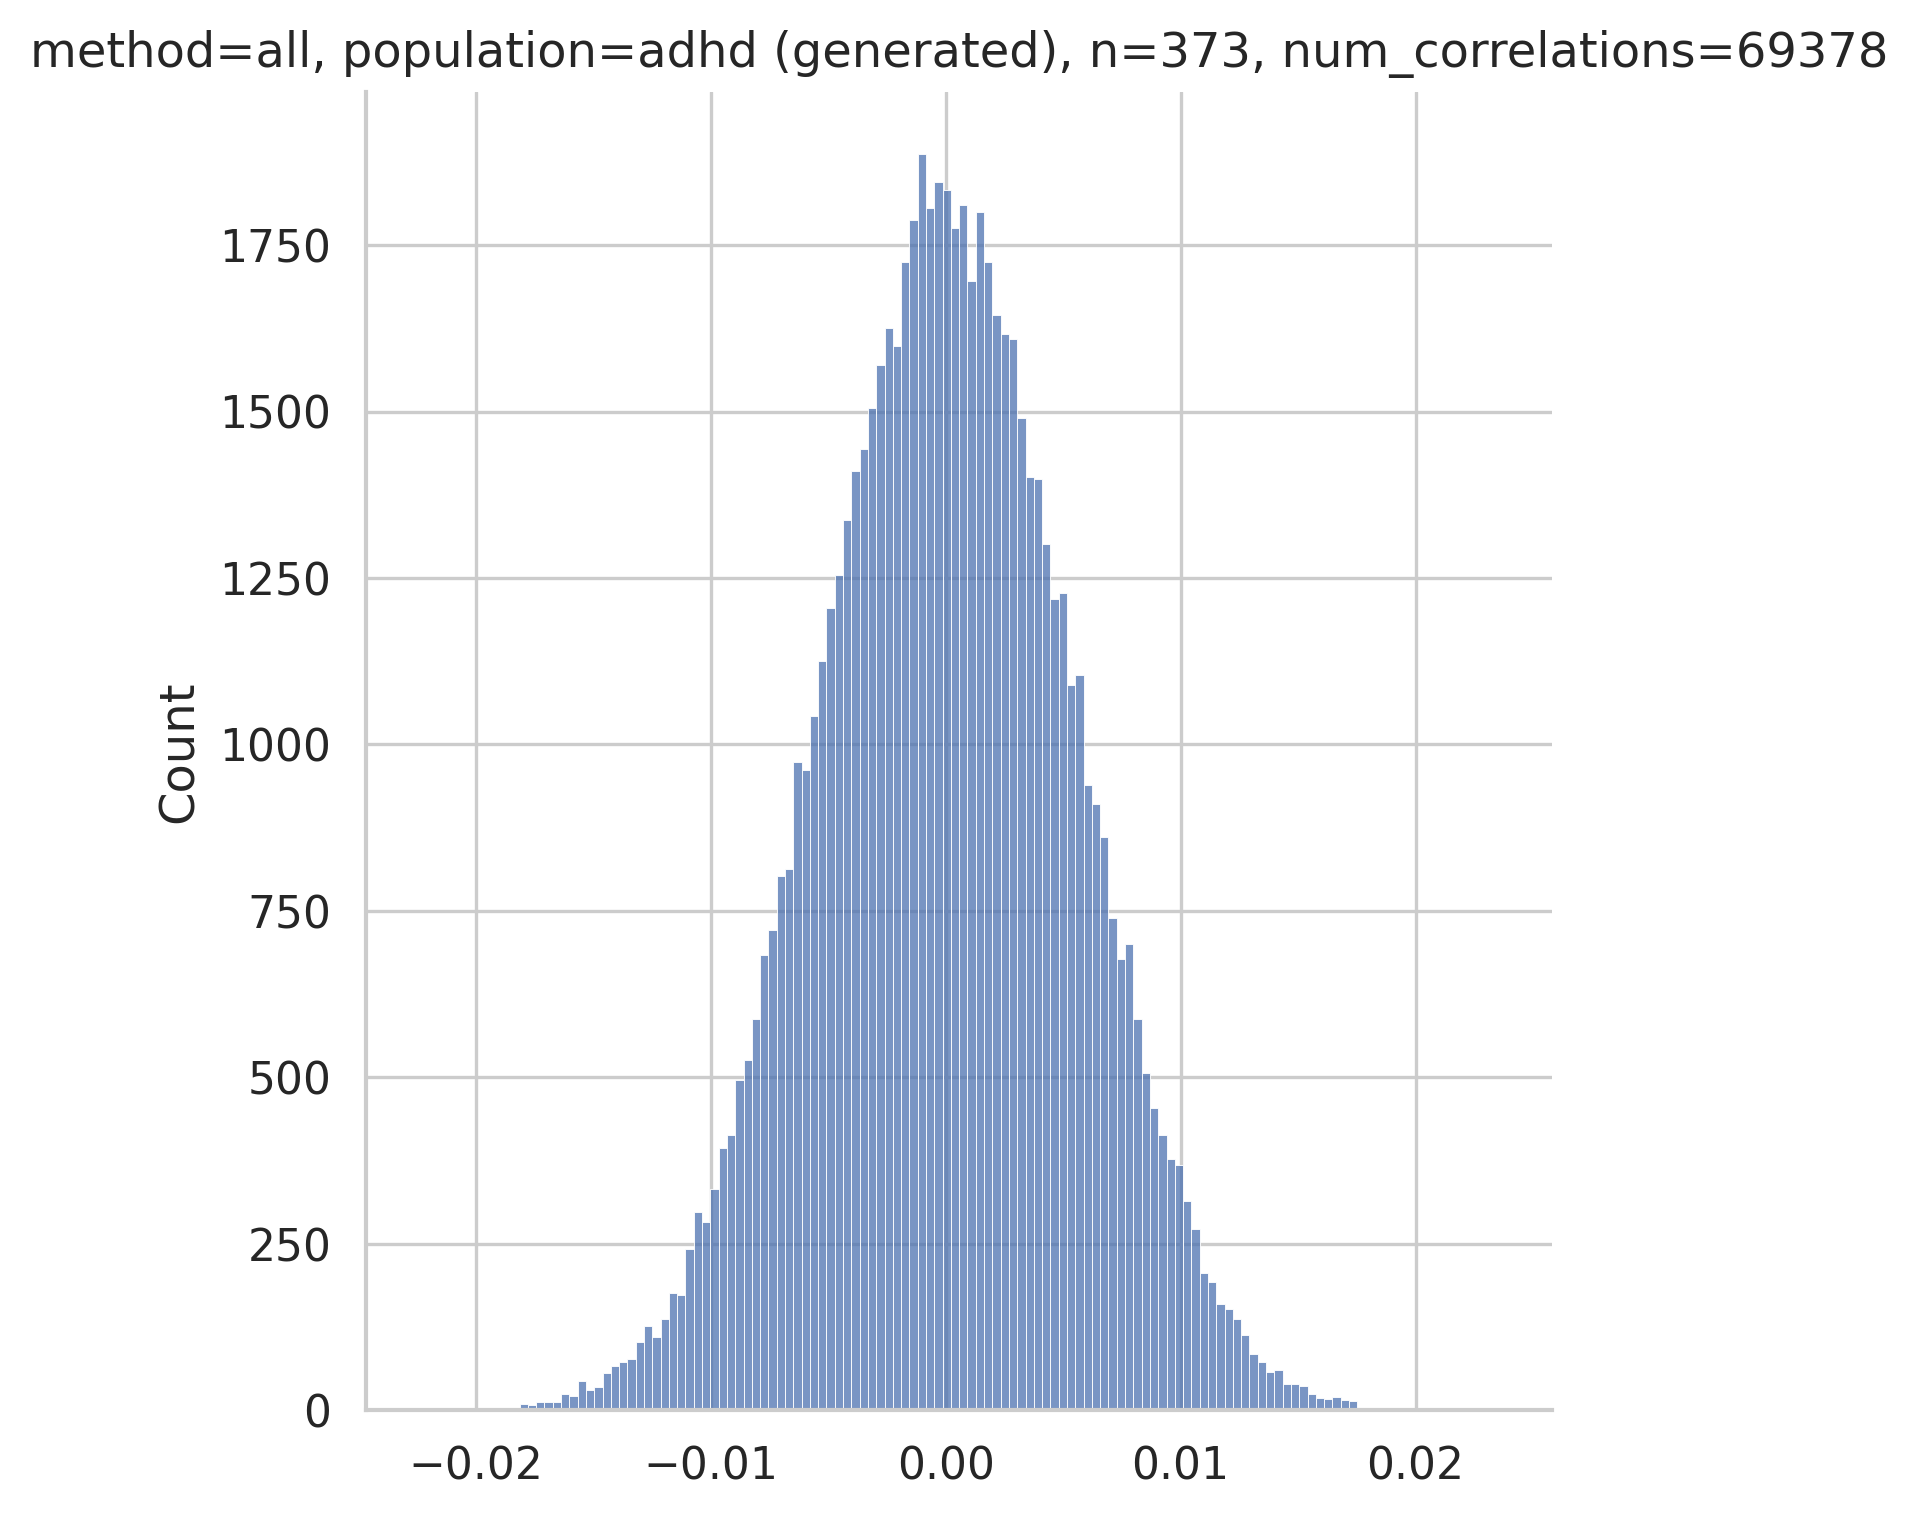

In [97]:
g = sns.displot(correlations)
g.ax.set_title(f'method=all, population={population}, n={len(X)}, num_correlations={len(correlations)}')

### Correlate every sample (leave-one-out)

In [18]:
X_loo = X_bins[0]
population = bin_labels[0]

correlations = []
bad_subjects = []
loo = LeaveOneOut()

for rest_subjects, curr_subject in loo.split(X_loo):
    X_curr, X_rest = X[curr_subject][0], X[rest_subjects]
    X_rest_mean = np.mean(X_rest, axis=0)
    r, p = stats.pearsonr(X_curr, X_rest_mean)
    correlations.append(r)

print(f'Num correlations: {len(correlations)}')

Num correlations: 114


Text(0.5, 1.0, 'method=loo, population=Bin 1, n=373, num_correlations=114')

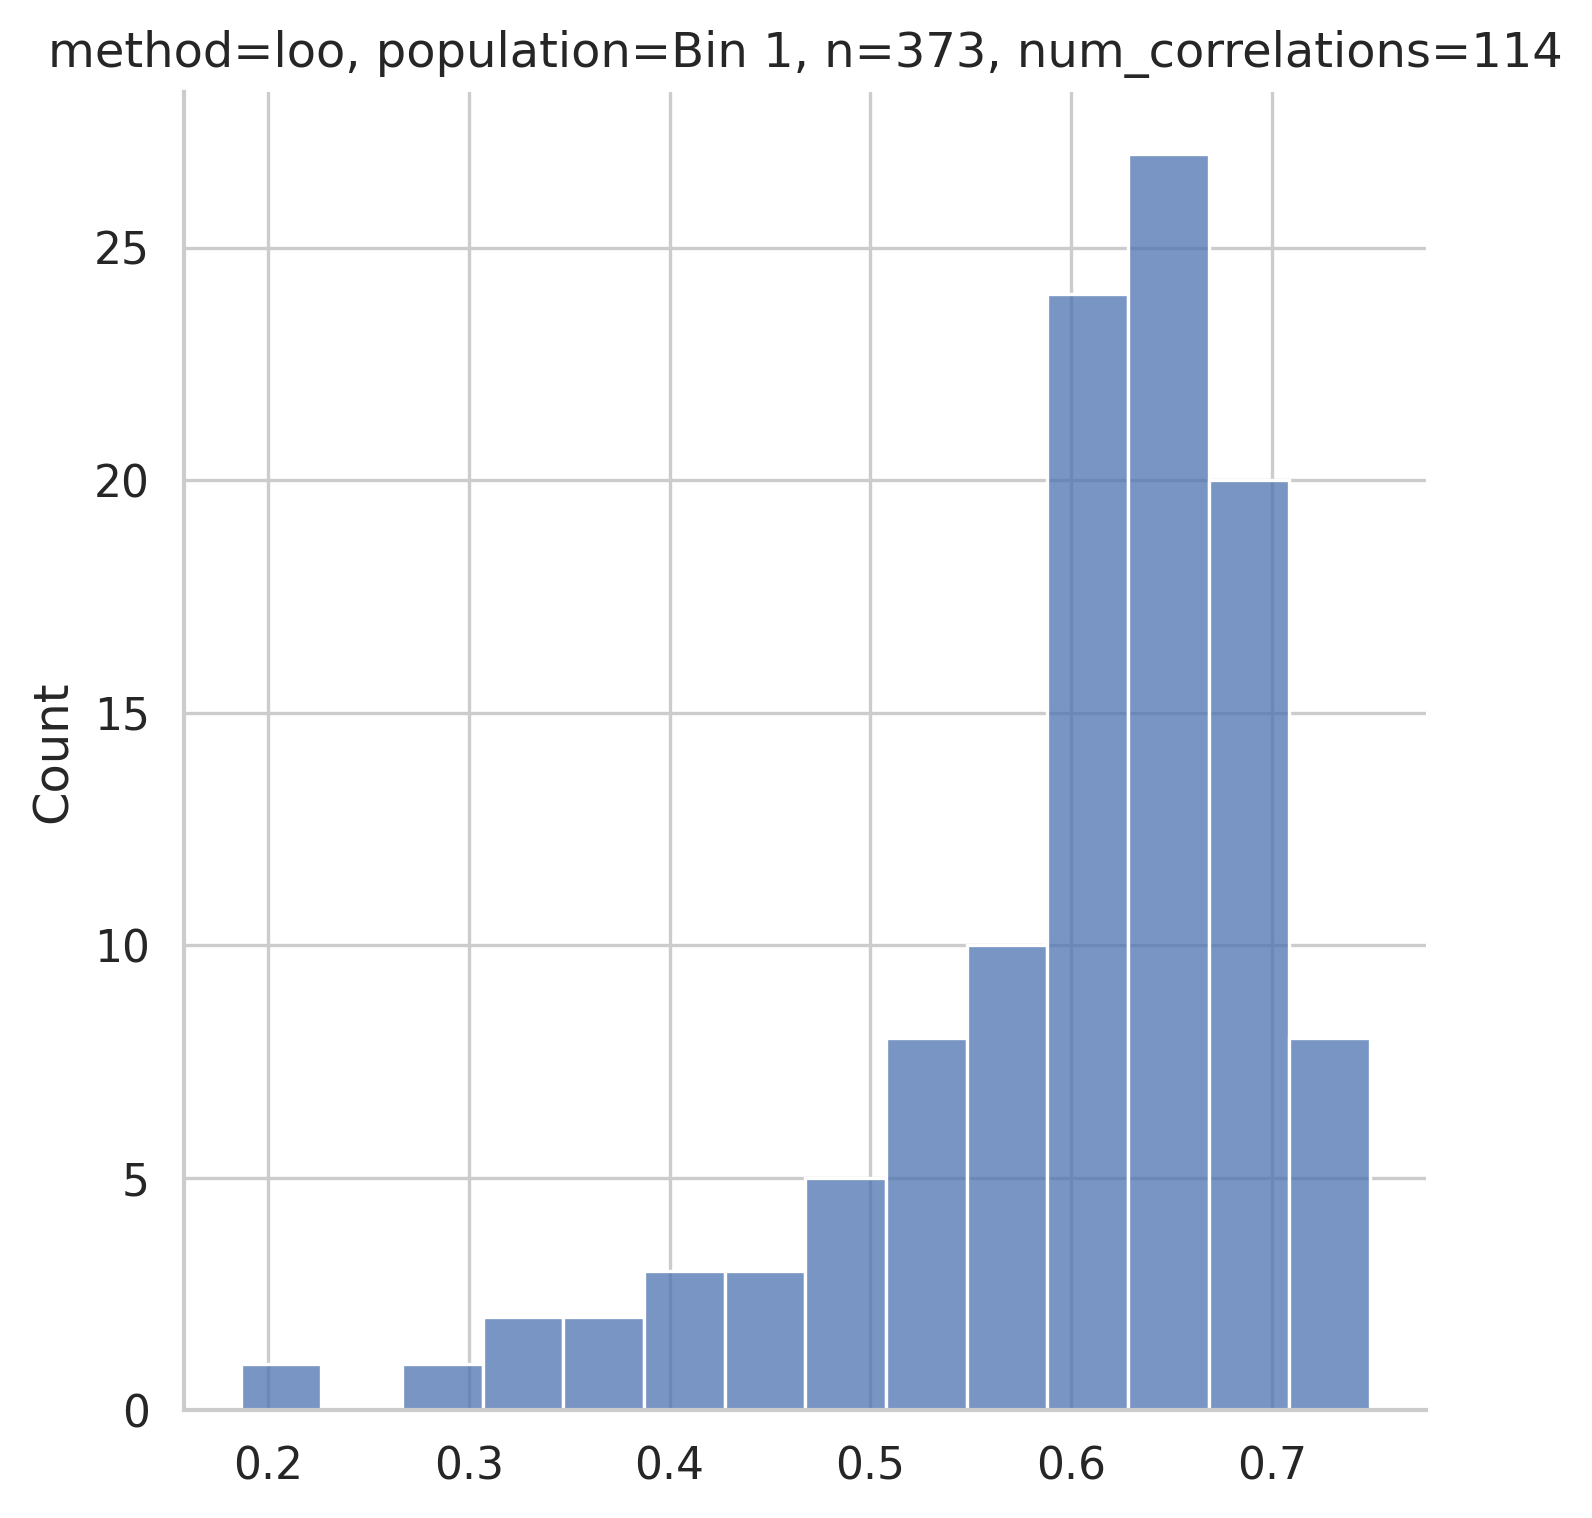

In [19]:
g = sns.displot(correlations)
g.ax.set_title(f'method=loo, population={population}, n={len(X)}, num_correlations={len(correlations)}')

## Cross Prediction Correlation

(34716,)


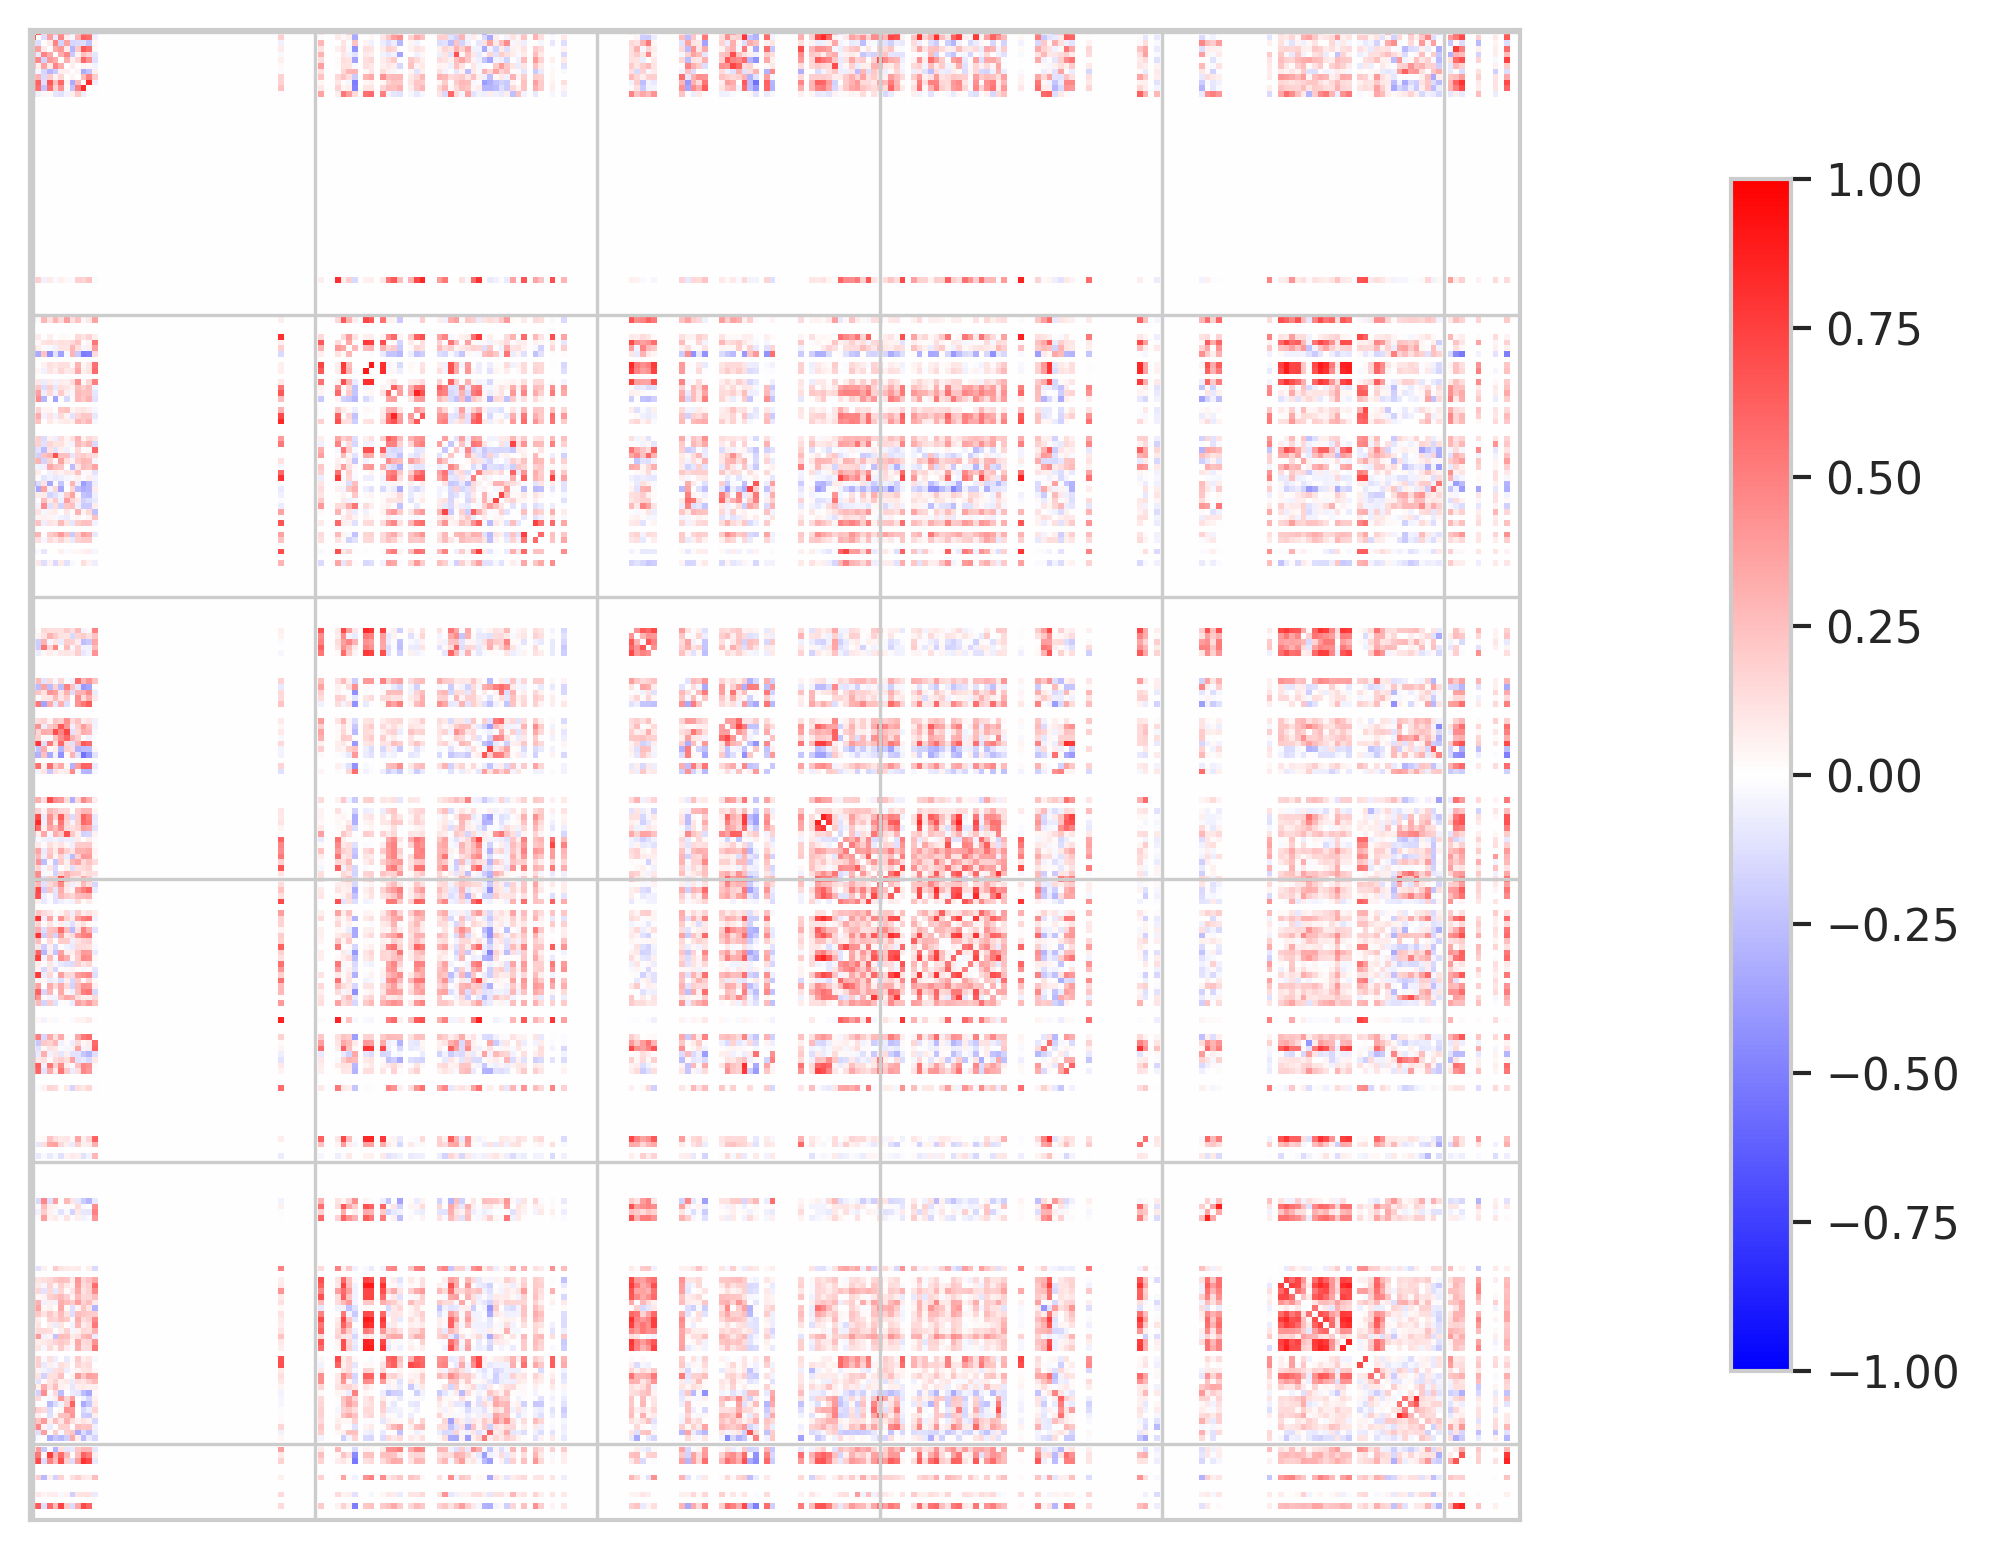

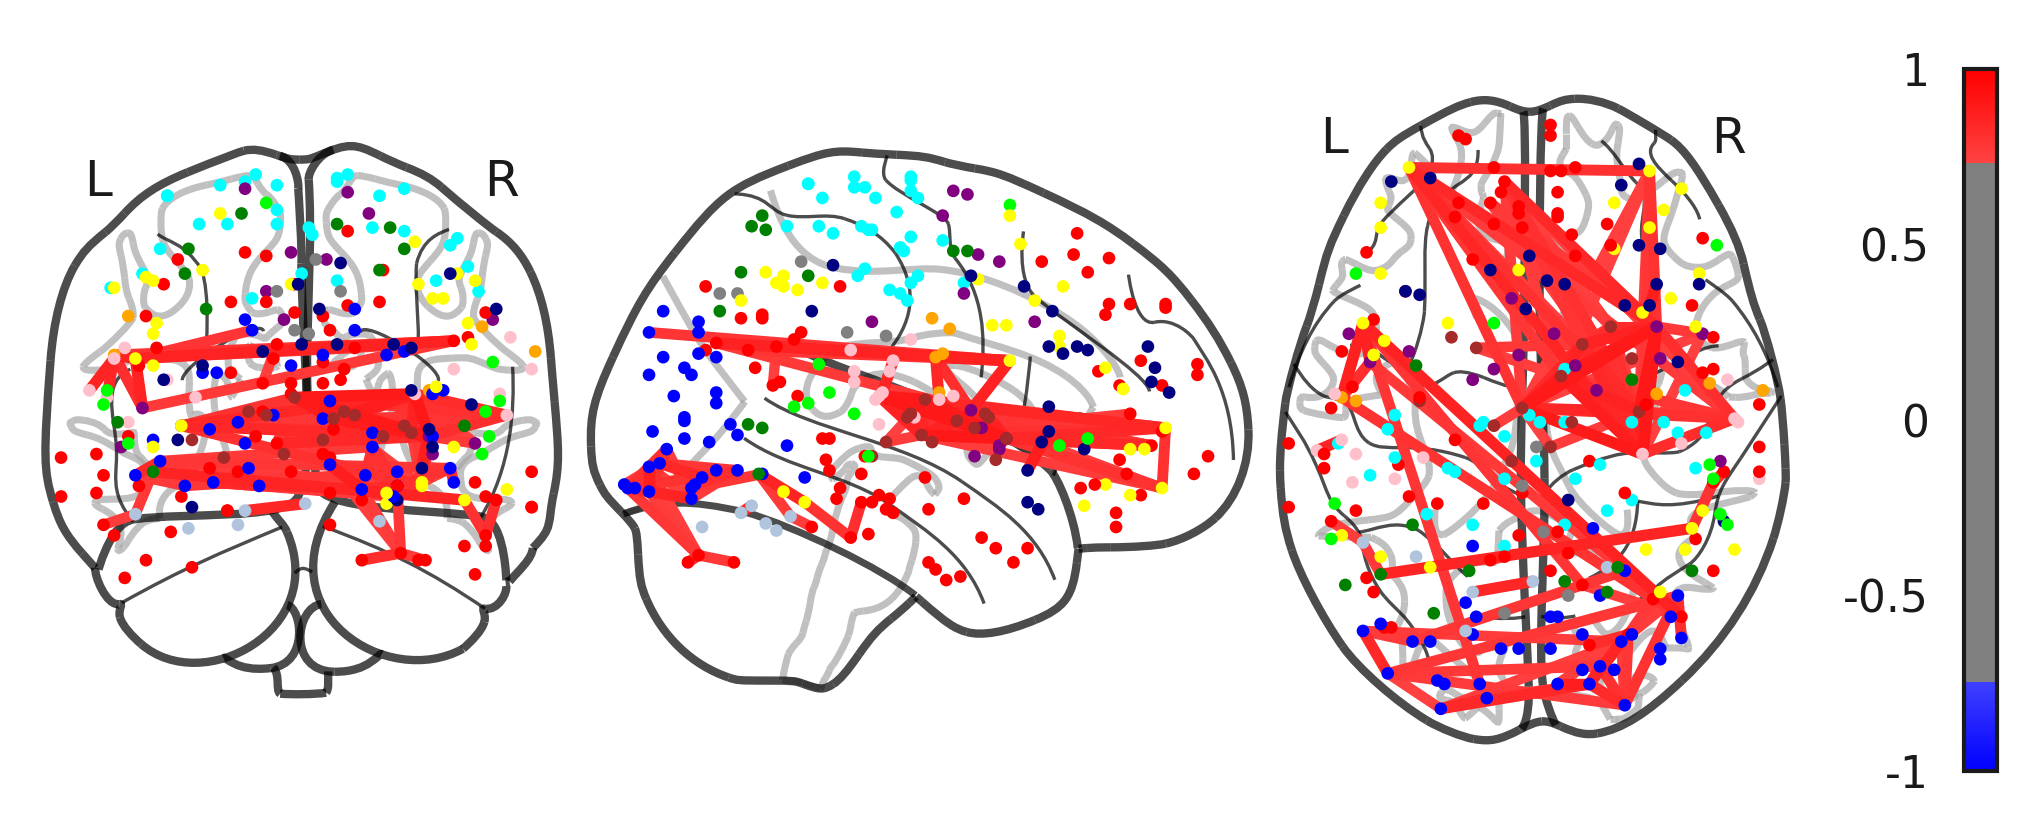

In [43]:
# This cell was used to find the sample that resulted in null correlations
from common.plotting import plot_connections

bin_means = [(np.mean(X_bin, axis=0), bin_label) for X_bin, bin_label in zip(X_bins, bin_labels)]
cross_pred_corr = []

for X_bin, bin_label in zip(X_bins, bin_labels):
    for bin_mean, bin_mean_label in bin_means:
        if bin_label != 'Bin 1':
            continue
            
        bin_correlations = [stats.pearsonr(sample, bin_mean)[0] for sample in X_bin]
        print(len(bin_correlations), np.argwhere(np.isnan(bin_correlations)))
        bin_mean_corr = np.mean(bin_correlations)
        print('mean', bin_mean_corr)
        cross_pred_corr.append({'Train': bin_label, 'Test': bin_mean_label, 'Mean': bin_mean_corr})

print(X_bins[0][51].shape)
plot_connections(X_bins[0][51], -1, 1, show_matrix=True, show_pos_neg=False)

In [132]:
bin_means = [(np.mean(X_bin, axis=0), bin_label) for X_bin, bin_label in zip(X_bins, bin_labels)]
cross_pred_corr = []

for X_bin, bin_label in zip(X_bins, bin_labels):
    for bin_mean, bin_mean_label in bin_means:          
        bin_correlations = [stats.pearsonr(sample, bin_mean)[0] for sample in X_bin]
        bin_mean_corr = np.mean(bin_correlations)
        cross_pred_corr.append({'Train': bin_label, 'Test': bin_mean_label, 'Mean': bin_mean_corr})
        
df = pd.DataFrame(cross_pred_corr)
display(df)

,Train,Test,Mean
0,Bin 1,Bin 1,0.726541
1,Bin 1,Bin 2,0.718629
2,Bin 1,Bin 3,0.713985
3,Bin 2,Bin 1,0.728692
4,Bin 2,Bin 2,0.737498
5,Bin 2,Bin 3,0.727545
6,Bin 3,Bin 1,0.718710
7,Bin 3,Bin 2,0.720851
8,Bin 3,Bin 3,0.730842


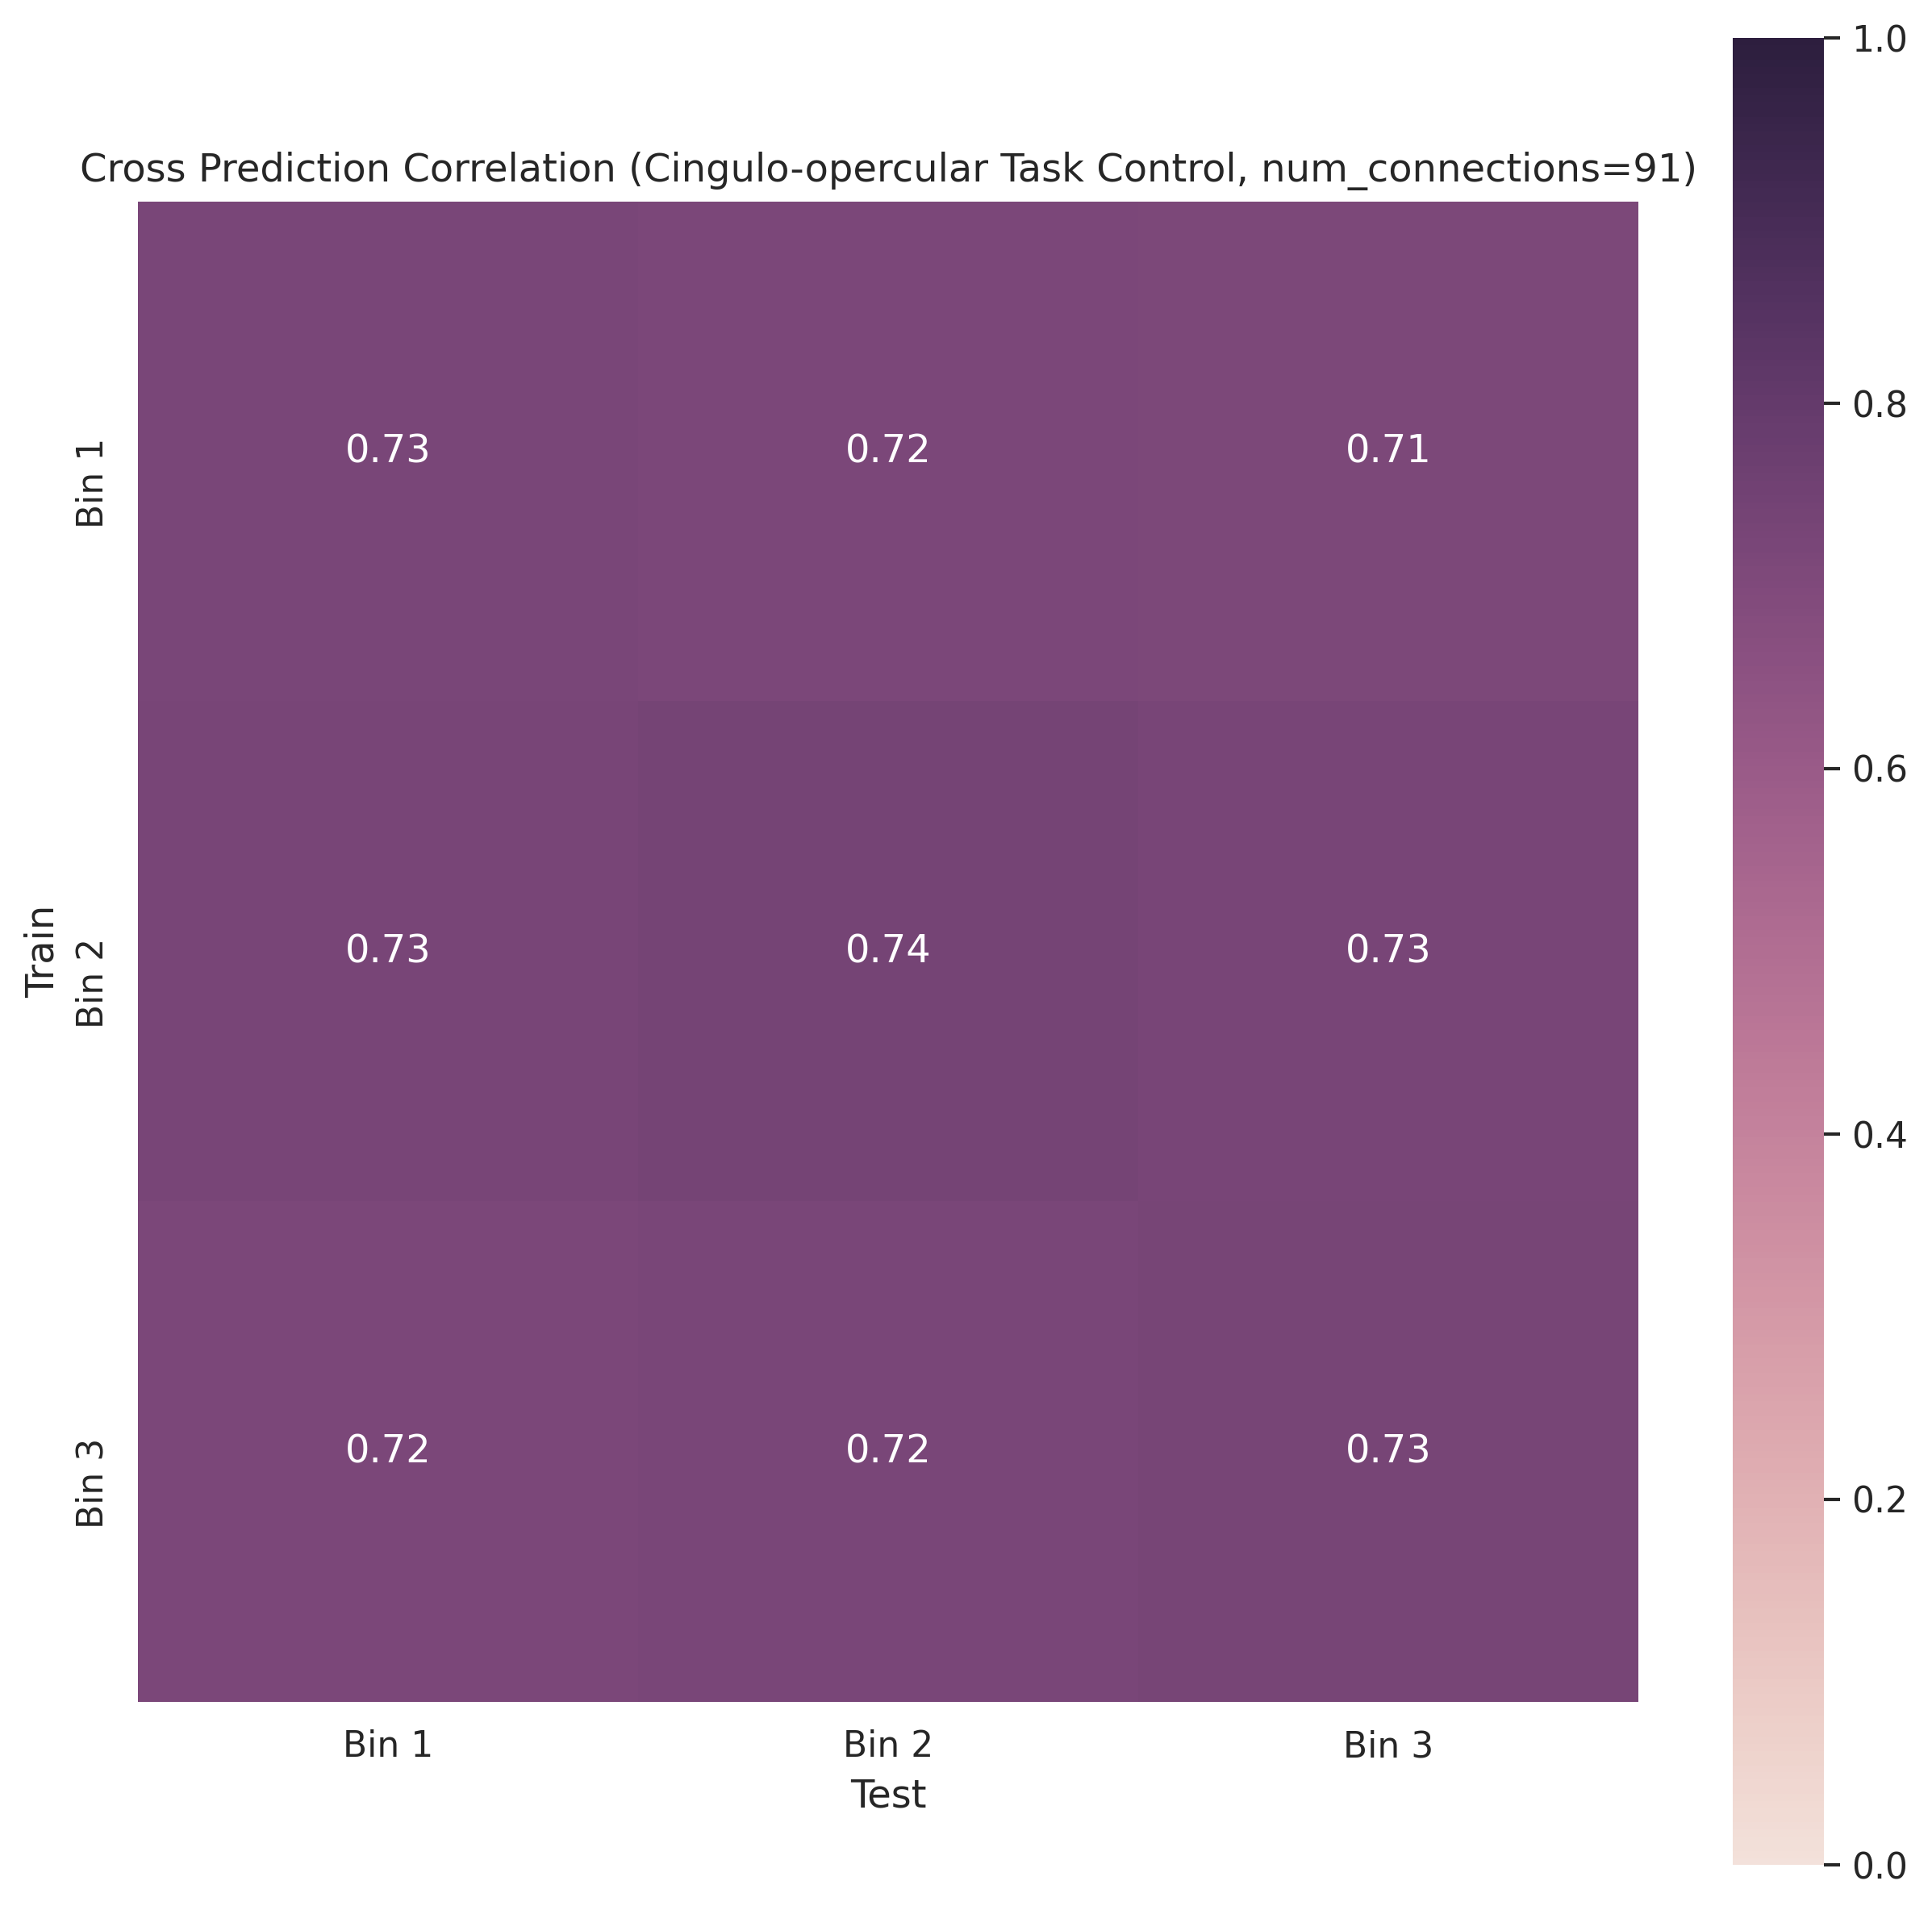

In [133]:
ax = sns.heatmap(df.pivot('Train', 'Test', 'Mean'), annot=True, fmt=".2f", 
                 cmap=sns.cubehelix_palette(as_cmap=True, light=.9), square=True,
                 vmin=0, vmax=1)
# ax.set_title(f'Cross Prediction Correlation (All, num_connections={X_bins[0].shape[1]})')
ax.set_title(f'Cross Prediction Correlation ({POWER_NETWORKS[network]}, num_connections={X_bins[0].shape[1]})')
plt.show()